# Expedia predict destination : 
The goal of this Kaggle competition is to predit the hotel of user

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from datetime import datetime
import xgboost as xgb
%matplotlib inline 

# Functions : 

In [2]:
def string_to_datetime(s, fmt='%Y-%m-%d'):
    if s != s:
        return np.nan
    year, month, day = s.split('-')
    try:  
        d = pd.datetime(int(year), int(month), int(day))
    except ValueError:
        d = pd.datetime(2017, 1, 1)
    d = min([max([d, pd.datetime(2013, 1, 1)]), pd.datetime(2017, 1, 1)])
    return d

# Explore and vizualise data : 

In [3]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv",nrows=90000)
destinations = pd.read_csv("destinations.csv")
submission = pd.read_csv("sample_submission.csv")
target = train.hotel_cluster

In [4]:
print "We have",train.shape[0], "train values and",train.shape[1],"variables and",test.shape[0],"test rows"

We have 90000 train values and 24 variables and 2528243 test rows


In [5]:
id = np.empty(2528243)
for i in range(2528243):
    id[i] = int(i)
id = np.array(id, dtype=np.int32)

In [6]:
train.orig_destination_distance.fillna(0,inplace=True)
test.orig_destination_distance.fillna(0,inplace=True)

In [7]:
train['srch_ci'] = train['srch_ci'].apply(string_to_datetime)
train['srch_co'] = train['srch_co'].apply(string_to_datetime)
test['srch_ci'] = test['srch_ci'].apply(string_to_datetime)
test['srch_co'] = test['srch_co'].apply(string_to_datetime)

In [8]:
train['hotel_nights'] = train['srch_co'] - train['srch_ci']
test['hotel_nights'] = test['srch_co'] - test['srch_co']

In [9]:
train.hotel_nights.fillna(0,inplace=True)
test.hotel_nights.fillna(0,inplace=True)
train = train.drop('srch_ci',1)
train = train.drop('srch_co',1)
test = test.drop('srch_ci',1)
test = test.drop('srch_co',1)

In [10]:
train['hotel_nights'] = train.hotel_nights
train.hotel_nights = (train.hotel_nights / np.timedelta64(1, 'D')).astype(float)
test.hotel_nights = (test.hotel_nights / np.timedelta64(1, 'D')).astype(float)

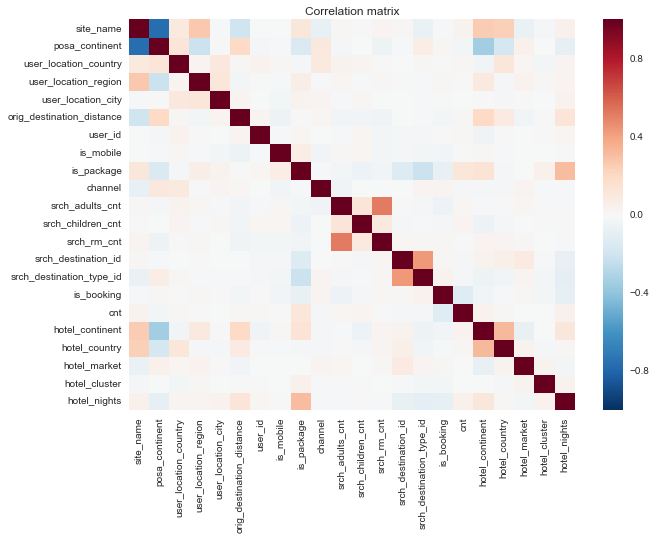

In [11]:
plt.figure(figsize=(10,7))
corr = train.corr()
sns.heatmap(corr)
plt.title("Correlation matrix")

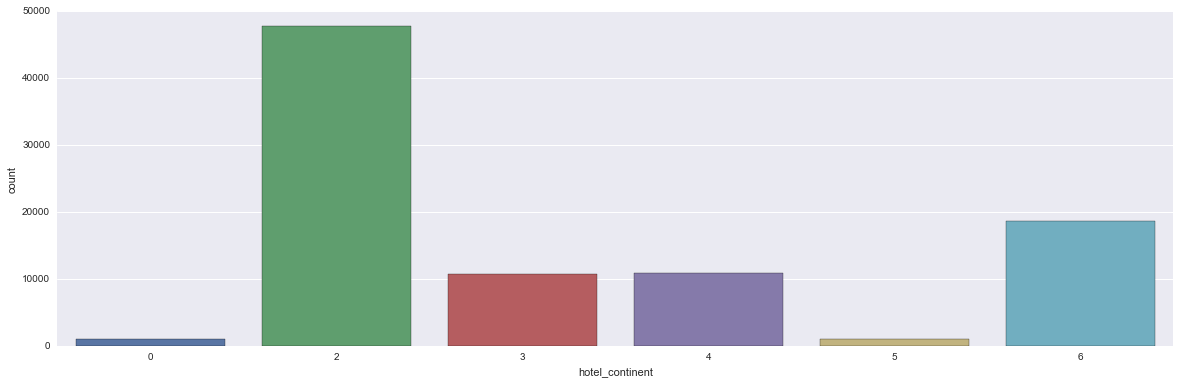

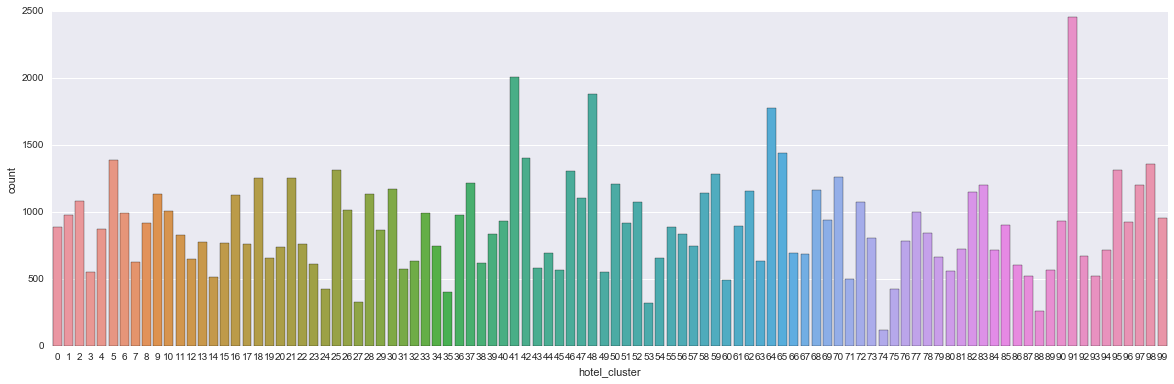

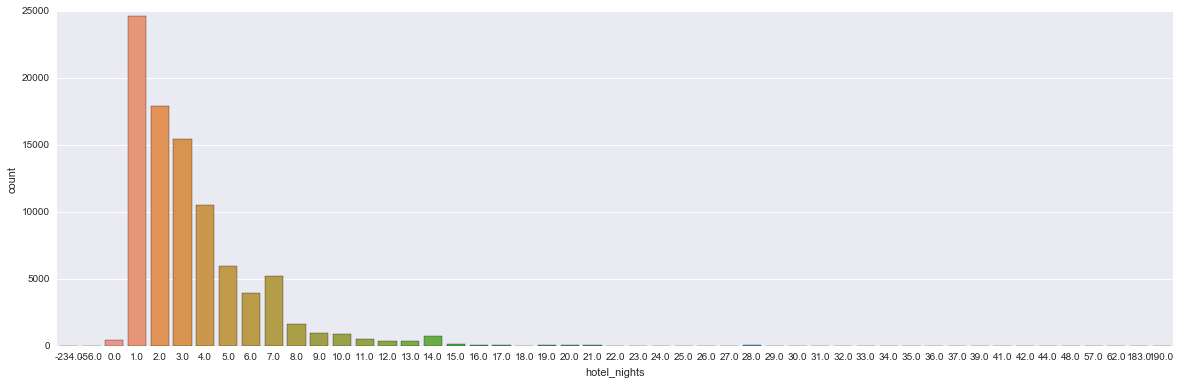

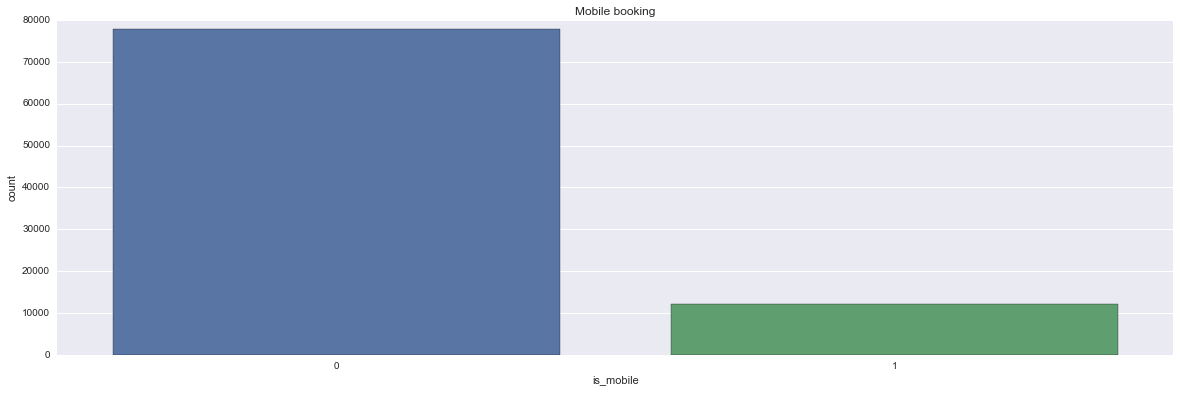

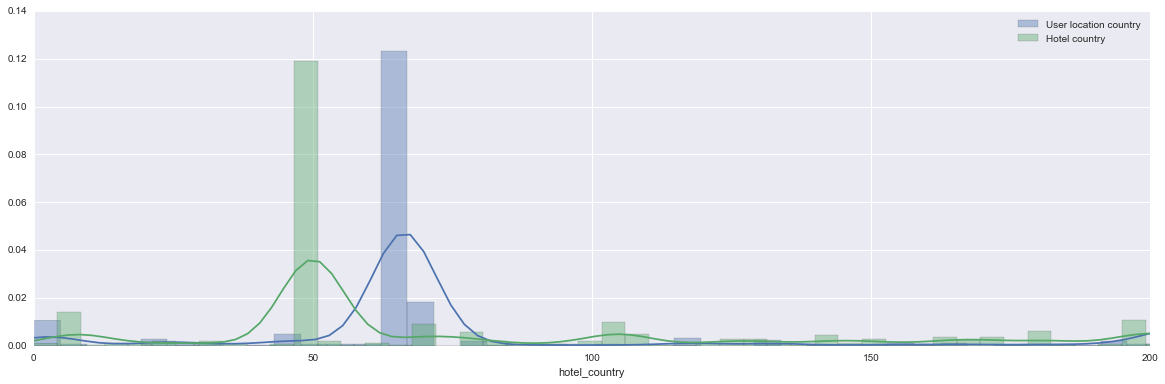

In [12]:
# Plot hotel continent histogram : 
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_continent)

# Plot hotel cluster histogram : 
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_cluster)

# Plot hotel nights histogram : 
plt.figure(figsize=(20,6))
sns.countplot(train.hotel_nights)

# Plot mobile booking 
plt.figure(figsize=(20,6))
sns.countplot(train.is_mobile)
plt.title("Mobile booking")

# Kde for user location country and hotel country
plt.figure(figsize=(20,6))
sns.distplot(train.user_location_country,label="User location country")
sns.distplot(train.hotel_country,label="Hotel country")
plt.xlim([0,200])
plt.legend()

We notice that most of booking is from continent 2, and the most reccurent hotel cluster is the cluster 91 and 41

In [13]:
print "The average of booking nights is : ",np.mean(train.hotel_nights)," nights by user"

The average of booking nights is :  3.3954  nights by user


In [14]:
columns = train.columns
for col in columns : 
    if(train[col].dtype !='object'):
        print col
        print(train[col].corr(train['hotel_cluster']))

site_name
-0.0163957153894
posa_continent
-0.000765061423944
user_location_country
-0.0253586726229
user_location_region
0.00907434065232
user_location_city
-0.00697180638086
orig_destination_distance
0.00476386229782
user_id
0.000193128939725
is_mobile
-0.00315135000209
is_package
0.0497962474918
channel
-0.00926404093212
srch_adults_cnt
0.00715048589491
srch_children_cnt
0.00456403497743
srch_rm_cnt
-0.00453669840681
srch_destination_id
-0.00809381135902
srch_destination_type_id
-0.030158618058
is_booking
-0.0251174199106
cnt
-0.000860721070951
hotel_continent
-0.00747703176077
hotel_country
-0.0228787951476
hotel_market
0.0337569659546
hotel_cluster
1.0
hotel_nights
0.0425452629657


In [15]:
train = train.drop('date_time',1)

In [16]:
lda = LDA(n_components = 3)
X_r = lda.fit(train,target).transform(train)
#pca = PCA(n_components = 2)
#X_r2 = pca.fit(train).transform(train)
#print('explained variance ratio (first two components): %s'% str(pca.explained_variance_ratio_))

/Users/aissaelouafi/Library/Python/2.7/lib/python/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


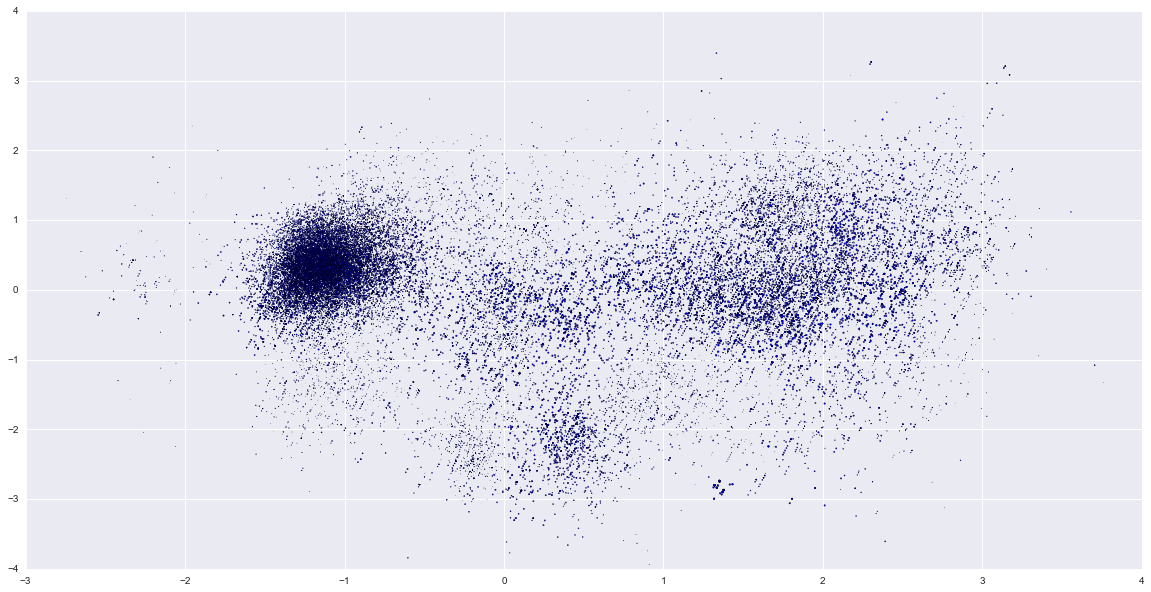

In [17]:
x = X_r[:,0]
y = X_r[:,1]
z = X_r[:,2]
plt.figure(figsize=(20,10))
plt.xlim([-3,4])
plt.ylim([-4,4])
plt.scatter(x, y, z)
plt.show()

In [18]:
test = test.drop('id',1)
test = test.drop('date_time',1)
train = train.drop('hotel_cluster',1)
train = train.drop('is_booking',1)
train = train.drop('cnt',1)

In [19]:
print "Train colmuns :",len(train.columns), "and test columns :",len(test.columns)

Train colmuns : 19 and test columns : 19


In [20]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=10)
model.fit(train, target)
predicts = model.predict(test)
predicts = [ ceil(x) for x in predicts ]
predicts = [ int(x) for x in predicts ]
submission = pd.DataFrame({"id":id, "hotel_cluster":predicts})
submission.to_csv("submission_rfc.csv", index=False)
rfs = pd.read_csv("submission_rfc.csv")

In [21]:
sub = pd.read_csv("submission_rfc.csv")
sub

,hotel_cluster,id
0,38,0
1,45,1
2,70,2
3,40,3
4,48,4
5,46,5
6,67,6
7,53,7
8,37,8
9,43,9
